In [ ]:
- získejte potřebné informace o filmech z TOP 1000 ze stránky www.csfd.cz
- vyhodnoťte filmy na základě délky, počtu hodnocení, výše hodnocení a dalších ukazatelů
- vytvořte přehledný report do PDF

In [ ]:


from selenium.webdriver import Chrome
from selenium.webdriver.chrome.service import Service as ChromeService

from selenium.webdriver.common.by import By

from pathlib import Path

from bs4 import BeautifulSoup

import os

In [ ]:
service = ChromeService()
browser = Chrome(service=service)

In [ ]:
browser.get('https://www.csfd.cz/zebricky/filmy/nejlepsi/')

In [ ]:
def submit_cookies(browser):
    try:
        button = browser.find_element(By.ID, "didomi-notice-agree-button")
        button.click()
    except:
        pass

In [ ]:
submit_cookies(browser)

In [ ]:
def make_directory(directory):
    path = Path(directory)
    path.mkdir(exist_ok=True)


In [ ]:
make_directory("pages")

In [ ]:
def save_file(filename, browser):
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(browser.page_source)

In [ ]:
def load_movies(browser):
    url_pattern = "https://www.csfd.cz/zebricky/filmy/nejlepsi/?from={page_from}"
    file_pattern = r"pages\movies_{page_from}.html"
    pages_from = [1] + list(range(100, 1000, 100))
    for page_from in pages_from:
        browser.get(url_pattern.format(page_from=page_from))
        save_file(file_pattern.format(page_from=page_from), browser)
#save_file(r'pages\movies_01.html', browser)

In [ ]:
load_movies(browser)

In [ ]:
def get_movies():
    movies = []

    for filename in os.listdir('pages'):
        if filename.endswith('.html'):
            data = open(f"pages/{filename}", encoding='utf-8').read()
            html = BeautifulSoup(data, 'html.parser')

            box = html.find('section', class_='box')
            articles = box.find_all('article')
            for article in articles:
                position = int(article.find('span', class_='film-title-user').text.strip().replace('.', ''))
                title = article.find('a', class_='film-title-name').text.strip()
                year = int(article.find('span', class_='film-title-info').text.strip().replace('(', '').replace(')', ''))
                rating_average = float(article.find('div', class_='rating-average').text.strip().replace('%', '').replace(',', '.'))
                rating_total = int(article.find('div', class_='rating-total').find(string=True).strip().replace('\xa0', ''))

                movies.append({
                    'position': position,
                    'title': title,
                    'year': year,
                    'rating_average': rating_average,
                    'rating_total': rating_total
                })

    return movies












In [ ]:
movies = get_movies()

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(movies)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   position        1000 non-null   int64  
 1   title           1000 non-null   object 
 2   year            1000 non-null   int64  
 3   rating_average  1000 non-null   float64
 4   rating_total    1000 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 39.2+ KB


,position,title,year,rating_average,rating_total
0,1,Vykoupení z věznice Shawshank,1994,95.4,113121
1,2,Forrest Gump,1994,94.4,128468
2,3,Zelená míle,1999,92.9,109311
3,4,Sedm,1995,92.4,98851
4,5,Přelet nad kukaččím hnízdem,1975,92.4,81347


In [ ]:
#pd.pivot_table(df[['year']], index=df['year'], aggfunc='count')

array([[<Axes: title={'center': 'position'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'rating_average'}>,
        <Axes: title={'center': 'rating_total'}>]], dtype=object)

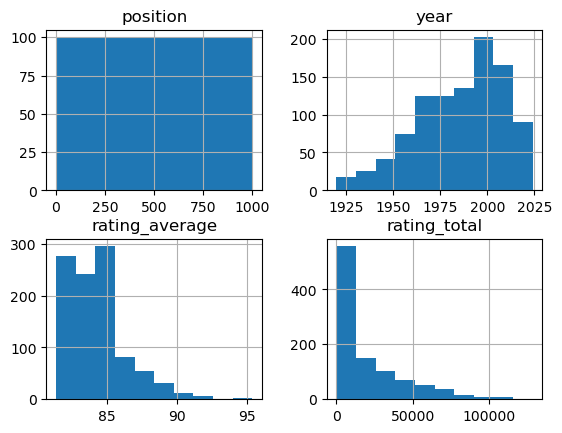

In [ ]:
df.hist()

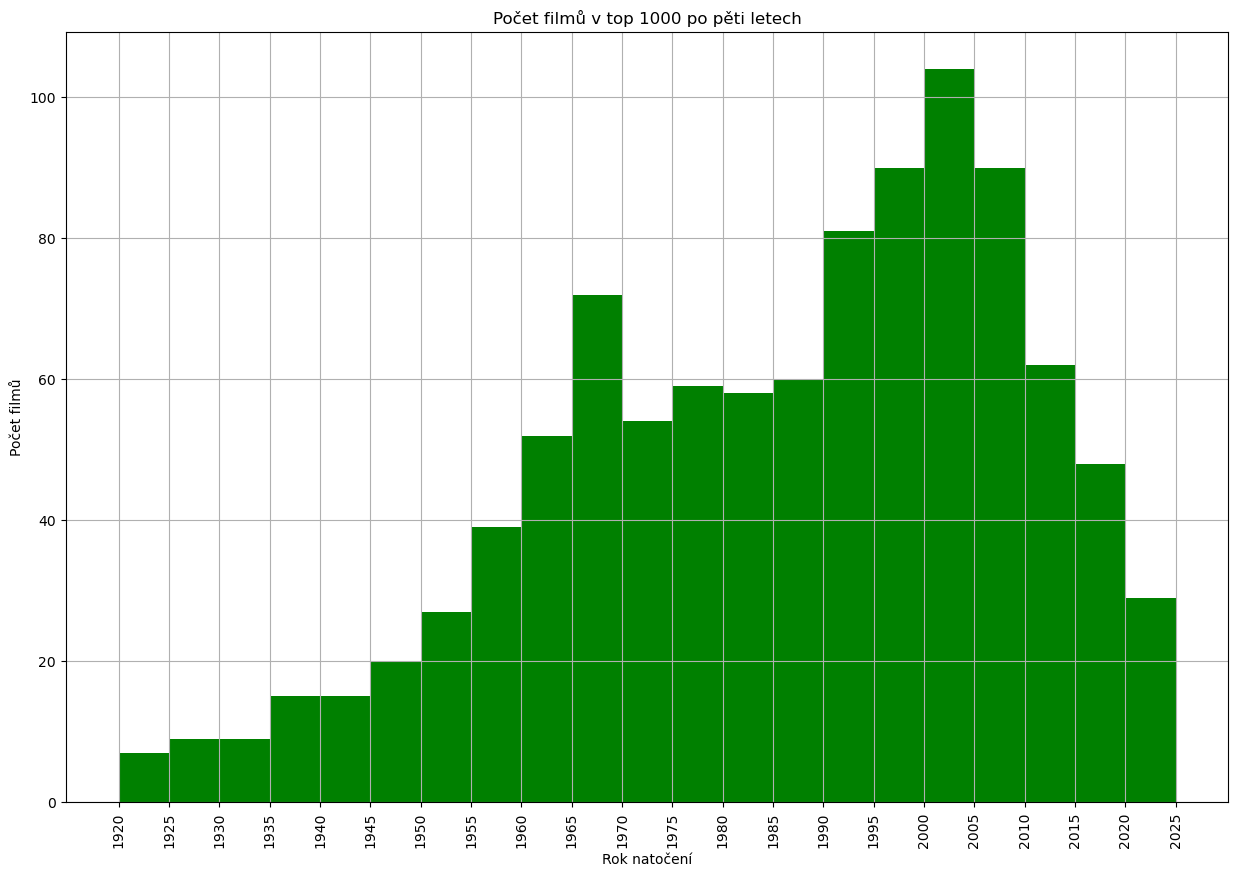

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.hist(df['year'], bins=range(1920, 2030, 5), color='green')
plt.grid()
plt.xticks(range(1920, 2030, 5), rotation=90)
plt.yticks(range(0, 110, 20))

plt.xlabel('Rok natočení')
plt.ylabel('Počet filmů')
plt.title('Počet filmů v top 1000 po pěti letech')
plt.savefig("histogram.png", format='png')
plt.show()

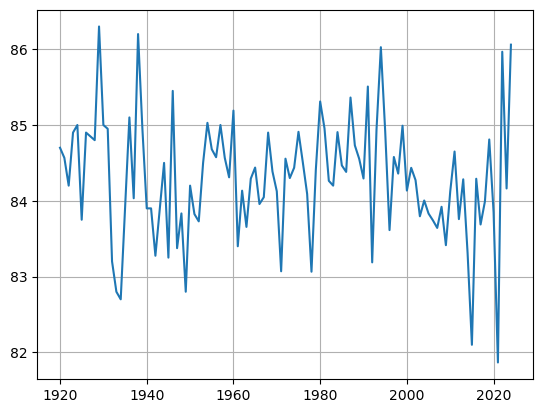

In [ ]:
rating_by_years_df = df.groupby(df['year'])['rating_average'].mean().reset_index()
plt.plot(rating_by_years_df['year'], rating_by_years_df['rating_average'])
plt.grid()
plt.savefig("hodnoceni_roky.png", format='png')
plt.show()

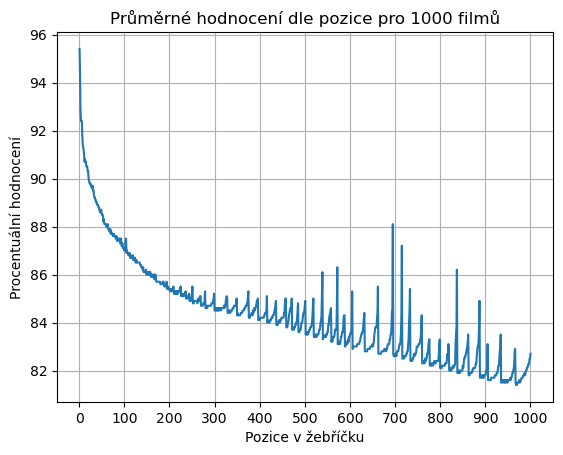

In [ ]:
plt.plot(df['position'], df['rating_average'])

plt.grid()
plt.xticks(range(0, 1001, 100))
plt.xlabel('Pozice v žebříčku')
plt.ylabel('Procentuální hodnocení')
plt.title('Průměrné hodnocení dle pozice pro 1000 filmů')
plt.savefig("průměrné hodnocení.png", format='png')
plt.show()

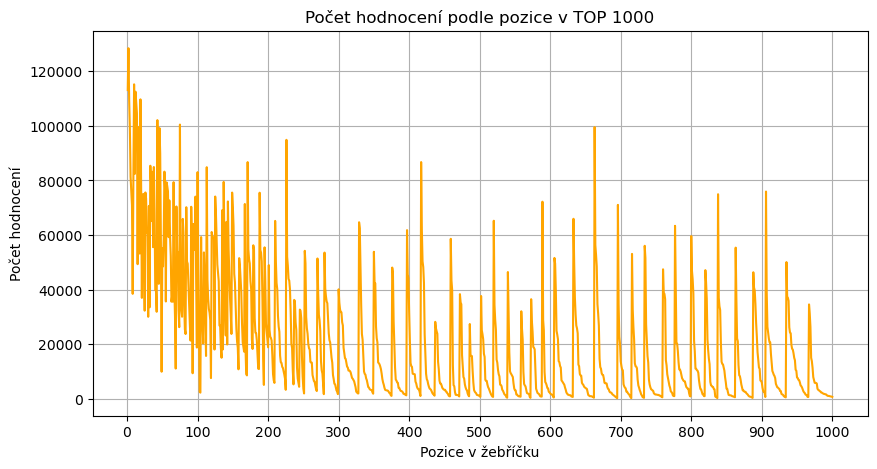

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df['position'], df['rating_total'], color='orange')

plt.grid()
plt.xticks(range(0, 1001, 100))

plt.xlabel("Pozice v žebříčku")
plt.ylabel("Počet hodnocení")
plt.title("Počet hodnocení podle pozice v TOP 1000")

plt.savefig("hodnoceni_pocet.png", format='png')
plt.show()

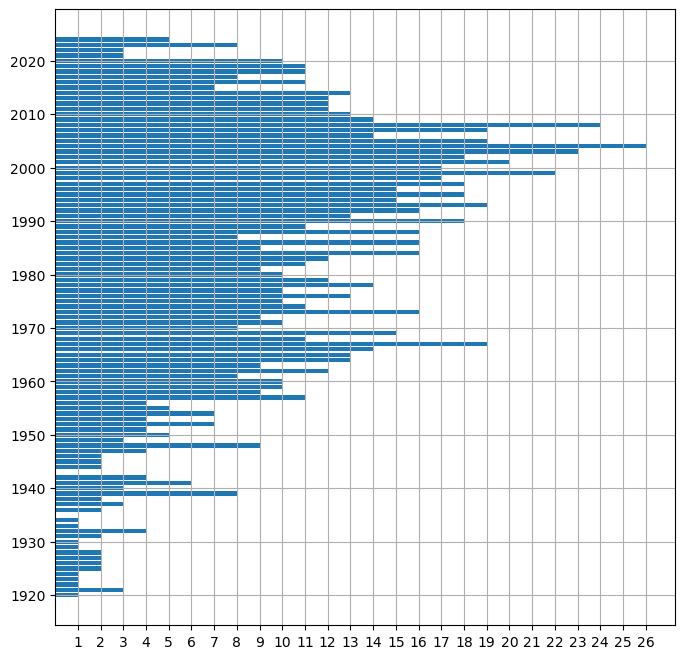

In [ ]:
df_year = df.groupby([df['year']])['year'].agg(['count']).reset_index().sort_values('count', ascending=False)

plt.figure(figsize=(8, 8))
plt.barh(df_year['year'], df_year['count'])
plt.yticks(range(min(df_year['year']), max(df_year['year'])+1, 10))
plt.xticks(range(min(df_year['count']), max(df_year['count'])+1, 1))
plt.grid()

plt.savefig("pocet_roky.png", format='png')

In [ ]:
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4

from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont

In [ ]:
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle

styles = getSampleStyleSheet()

doc = SimpleDocTemplate("workshop.pdf")
story = []

title = Paragraph("Rozbor TOP 1000 filmů z CSFD.cz", styles['title'])
story.append(title)

doc.build(story)

In [ ]:
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors

from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont

pdfmetrics.registerFont(TTFont('TimesNewRoman', 'times.ttf'))
pdfmetrics.getRegisteredFontNames()

styles = getSampleStyleSheet()
styles['title'].fontName = "TimesNewRoman"
styles['Heading1'].fontName = "TimesNewRoman"
doc = SimpleDocTemplate("workshop.pdf")
story = []

title = Paragraph("Rozbor TOP 1000 filmů z CSFD.cz", styles['title'])
story.append(title)
story.append(Spacer(1, 25))
logo = Image('https://img.csfd.cz/documents/marketing/logos/logo-white-black/logo-white-black-small.png')
story.append(logo)

story.append(PageBreak())

heading = Paragraph("Grafy".upper(), styles['Heading1'])
story.append(heading)

histogram = Image("histogram.png", 600, 300)
story.append(histogram)

histogram = Image("hodnoceni_pocet.png", 600, 300)
story.append(histogram)

story.append(PageBreak())

histogram = Image("hodnoceni_roky.png", 600, 300)
story.append(histogram)

histogram = Image("pocet_roky.png", 600, 300)
story.append(histogram)

story.append(PageBreak())

data = [["Pozice", "Název", "Rok", "%", "Počet hodn."]] + df.values.tolist()

ts = TableStyle([
    ('FONT', (0, 0), (-1, -1), 'TimesNewRoman', 10),
    ('BOX', (0, 0), (-1, -1), 0.7, colors.black),
    ('GRID', (0, 0), (-1, -1), 0.25, colors.black)
])

table = Table(data=data, style=ts, repeatRows=1)
story.append(table)


doc.build(story)